In [16]:
!pip install -q -U google-generativeai

import pandas as pd
from google.cloud import aiplatform
import time
from google.generativeai.types import HarmCategory, HarmBlockThreshold

# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY='---'
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

data = pd.read_csv("samsum-test.csv", nrows=120)
articles = data[['id', 'dialogue']]

# Initialize the Vertex AI client
PROJECT_ID = "gen-lang-client-0072808803"  # Replace with your Google Cloud project ID
LOCATION = "us-central1"  # Adjust based on your Google Cloud setup



In [25]:
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Function to generate highlights using the API
def generate_highlight(article):
    try:
        response = model.generate_content(
        ["Give the summary of the dialogue no bullet points and no more than 20 words",  article],
        generation_config=genai.types.GenerationConfig(
            max_output_tokens=80,
            candidate_count=1,
            temperature=0.05,
        )
    )
        return response.text
    except Exception as e:
        return f"Error: {str(e)}"

# Generate and print highlights for each article
results = []
for index, row in articles.iterrows():
    article_id = row['id']
    article_text = row['dialogue']
    highlight = generate_highlight(article_text)
    results.append([article_id, article_text, highlight])  # Store all three
    time.sleep(1)

results_df = pd.DataFrame(results, columns=['id', 'dialogue', 'summary'])

In [18]:
!pip install openai==0.28

In [19]:
# Assuming your generated summaries are in the 'summary' column of 'results_df'
# and the reference summaries are in a CSV file named 'samsum-test.csv'
# under the column name 'summary'

# Load reference summaries
reference_df = pd.read_csv("samsum-test.csv", nrows=120)  # Assuming same number of rows for comparison

# Filter out rows with system errors
filtered_results_df = results_df[~results_df['summary'].str.startswith("Error:")]
filtered_reference_df = reference_df[reference_df.index.isin(filtered_results_df.index)]  # Filter reference based on filtered results

filtered_reference_df[['id', 'dialogue', 'summary']].to_csv('filtered_reference_summaries.csv', index=False)
filtered_results_df[['id', 'dialogue', 'summary']].to_csv('gemini.csv', index=False)

In [20]:
!pip install python-dotenv
import openai
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
# api key is in the .env file
openai.api_key = os.getenv("OPENAI_API_KEY")
df = pd.read_csv('filtered_reference_summaries.csv', nrows=120)

def generate_summary(dialogue):
    # prompt
    prompt = f"""Give the summary of the dialogue no bullet points and no more than 20 words.

    Dialogue: {dialogue}

    Summary:"""
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an expert in summarizing dialogues."},
                {"role": "user", "content": prompt}
            ]
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        return f"Error: {e}"
df['summary'] = df['dialogue'].apply(generate_summary)
df[['id', 'dialogue', 'summary']].to_csv("gpt.csv", index=False)
print("Results saved to gpt.csv")

Results saved to gpt.csv


In [21]:
!pip install -U sentence-transformers
!pip install bert-score
!pip install stanza
import stanza

stanza.download('en')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


Computing BLEU Scores...
Computing BERT Scores...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing Embedding Similarities...


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Computing Sentiment Alignment...


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: sentiment
INFO:stanza:Done loading processors!



Evaluation  for OpenAI:
BLEU Score (avg): 0.0335
BERTScore (avg F1): 0.3945
Embedding Similarity (avg): 0.7326
Sentiment Alignment (avg): 0.6575

Evaluation  for Gemini:
BLEU Score (avg): 0.0383
BERTScore (avg F1): 0.4274
Embedding Similarity (avg): 0.7441
Sentiment Alignment (avg): 0.6164
Visualizing and Saving Metrics...
Saved BLEU plot to plots/bleu_comparison.png


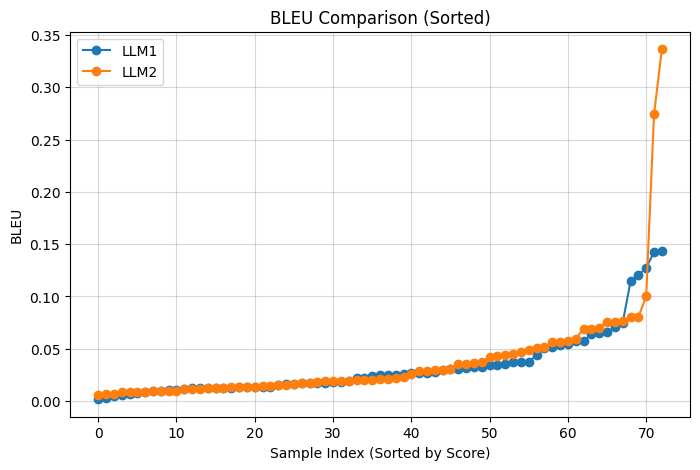

Saved BERTScore plot to plots/bertscore_comparison.png


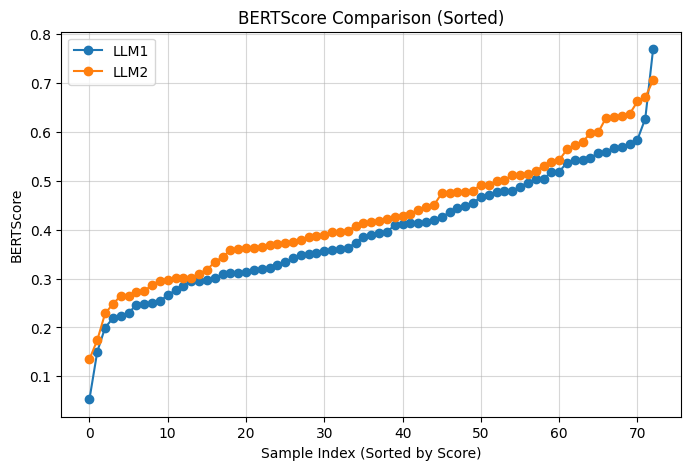

Saved Embedding Similarity plot to plots/embedding similarity_comparison.png


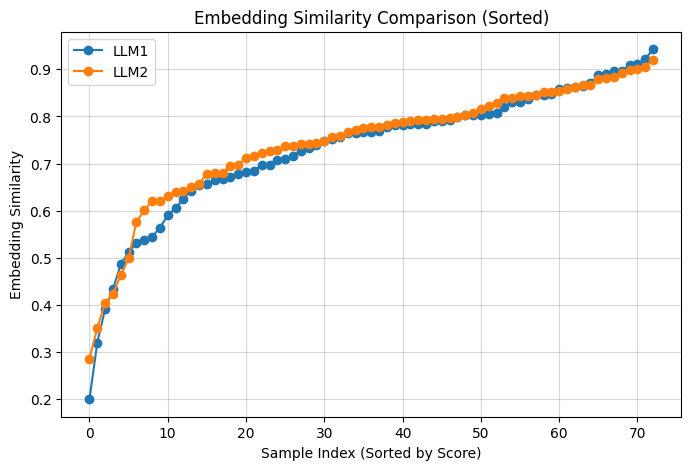

Saved Sentiment Alignment plot to plots/sentiment alignment_comparison.png


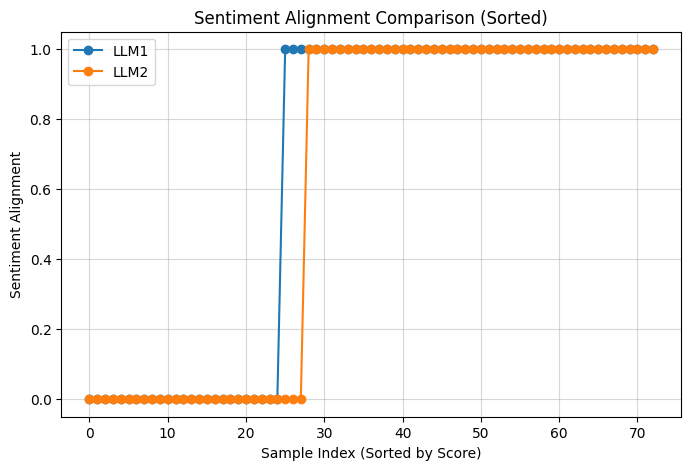

Summary of Metrics:
BLEU - LLM1 Avg: 0.0335, LLM2 Avg: 0.0383
BERTScore - LLM1 Avg: 0.3945, LLM2 Avg: 0.4274
Embedding Similarity - LLM1 Avg: 0.7326, LLM2 Avg: 0.7441
Sentiment Alignment - LLM1 Avg: 0.6575, LLM2 Avg: 0.6164


In [22]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import numpy as np


# load data
def load_data(gemini_file, gpt_file, dataset_file):
    gpt = pd.read_csv(gpt_file)
    gemini = pd.read_csv(gemini_file)
    golden = pd.read_csv(dataset_file)

    gemini_highlights = gemini['summary'].tolist()
    gpt_highlights = gpt['summary'].tolist()
    golden_highlights = golden['summary'].tolist()

    return gemini_highlights, gpt_highlights, golden_highlights

# BLEU Score
def compute_bleu_scores(gold_responses, model_responses):
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1
    for gold, model in zip(gold_responses, model_responses):
        bleu_scores.append(sentence_bleu([gold.split()], model.split(), smoothing_function=smooth_fn))
    return bleu_scores

# BERT Score
def compute_bertscore(gold_responses, model_responses):
    P, R, F1 = score(model_responses, gold_responses, lang="en", rescale_with_baseline=True)
    return F1.tolist()

# Embedding Similarity
def compute_embedding_similarity(gold_responses, model_responses, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    gold_embeddings = model.encode(gold_responses)
    model_embeddings = model.encode(model_responses)
    similarities = [cosine_similarity([g], [m])[0][0] for g, m in zip(gold_embeddings, model_embeddings)]
    return similarities

# Sentiment Alignment
def compute_sentiment_alignment(gold_responses, model_responses):

    # Load Stanza pipeline with both 'tokenize' and 'sentiment' processors
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

    # Process and compute sentiment alignment
    gold_sentiments = [nlp(text).sentences[0].sentiment for text in gold_responses]
    model_sentiments = [nlp(text).sentences[0].sentiment for text in model_responses]
    alignment = [1 if g == m else 0 for g, m in zip(gold_sentiments, model_sentiments)]

    return alignment

def visualize_sorted_scores(scores, metric_name, model_names, save_path=None):
    """
    Creates a line plot for a given metric with sorted scores for each model and saves the plot.

    Args:
        scores (list of lists): Scores for each model to plot.
        metric_name (str): Name of the metric (e.g., BLEU, BERTScore).
        model_names (list of str): Names of the models being compared (e.g., ["LLM1", "LLM2"]).
        save_path (str, optional): Path to save the plot (e.g., "plots/bleu_comparison.png"). Default is None.
    """
    plt.figure(figsize=(8, 5))

    # Sort scores for each model
    sorted_scores = [sorted(model_scores) for model_scores in scores]

    # Plot lines for each model
    for i, model_scores in enumerate(sorted_scores):
        plt.plot(model_scores, label=model_names[i], marker='o', linestyle='-')

    plt.title(f"{metric_name} Comparison (Sorted)")
    plt.xlabel("Sample Index (Sorted by Score)")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved {metric_name} plot to {save_path}")

    # Show the plot
    plt.show()

# Main program
if __name__ == "__main__":

    # File paths
    gemini_file = 'gemini.csv'
    gpt_file = 'gpt.csv'
    dataset_file = 'filtered_reference_summaries.csv'

    # Load the data
    gemini_highlights, gpt_highlights, golden_highlights = load_data(gemini_file, gpt_file, dataset_file)

    # Compute metrics
    print("Computing BLEU Scores...")
    bleu_gpt = compute_bleu_scores(golden_highlights, gpt_highlights)
    bleu_gemini = compute_bleu_scores(golden_highlights, gemini_highlights)

    print("Computing BERT Scores...")
    bert_gpt = compute_bertscore(golden_highlights, gpt_highlights)
    bert_gemini = compute_bertscore(golden_highlights, gemini_highlights)

    print("Computing Embedding Similarities...")
    similarity_gpt = compute_embedding_similarity(golden_highlights, gpt_highlights)
    similarity_gemini = compute_embedding_similarity(golden_highlights, gemini_highlights)

    print("Computing Sentiment Alignment...")
    sentiment_gpt = compute_sentiment_alignment(golden_highlights, gpt_highlights)
    sentiment_gemini = compute_sentiment_alignment(golden_highlights, gemini_highlights)

    # Print the results
    print("\nEvaluation  for OpenAI:")
    print(f"BLEU Score (avg): {np.mean(bleu_gpt):.4f}")
    print(f"BERTScore (avg F1): {np.mean(bert_gpt):.4f}")
    print(f"Embedding Similarity (avg): {np.mean(similarity_gpt):.4f}")
    print(f"Sentiment Alignment (avg): {np.mean(sentiment_gpt):.4f}")


    print("\nEvaluation  for Gemini:")
    print(f"BLEU Score (avg): {np.mean(bleu_gemini):.4f}")
    print(f"BERTScore (avg F1): {np.mean(bert_gemini):.4f}")
    print(f"Embedding Similarity (avg): {np.mean(similarity_gemini):.4f}")
    print(f"Sentiment Alignment (avg): {np.mean(sentiment_gemini):.4f}")


    metrics = ["BLEU", "BERTScore", "Embedding Similarity", "Sentiment Alignment"]
    model_scores = {
        "BLEU": [bleu_gpt, bleu_gemini],
        "BERTScore": [bert_gpt, bert_gemini],
        "Embedding Similarity": [similarity_gpt, similarity_gemini],
        "Sentiment Alignment": [sentiment_gpt, sentiment_gemini]
    }


    # Directory to save plots
    output_dir = "plots"
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Visualize and save sorted metrics
    print("Visualizing and Saving Metrics...")
    for metric, scores in model_scores.items():
        save_path = os.path.join(output_dir, f"{metric.lower()}_comparison.png")
        visualize_sorted_scores(scores, metric, model_names=["LLM1", "LLM2"], save_path=save_path)

    # Aggregate results
    print("Summary of Metrics:")
    for metric, scores in model_scores.items():
        print(f"{metric} - LLM1 Avg: {np.mean(scores[0]):.4f}, LLM2 Avg: {np.mean(scores[1]):.4f}")

In [23]:
similarity_models = compute_embedding_similarity(gpt_highlights, gemini_highlights)
print(f"Embedding Similarity (avg): {np.mean(similarity_models):.4f}")



sentiment_models = compute_sentiment_alignment(gpt_highlights, gemini_highlights)
print(f"Sentiment Alignment (avg): {np.mean(sentiment_models):.4f}")

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Embedding Similarity (avg): 0.8184


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode un

Sentiment Alignment (avg): 0.6438
